In [1]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import jax3dp3.transforms_3d as t3d
import jax3dp3 as j
from dataclasses import dataclass
import sys

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")

intrinsics = j.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.001, far=5.0
)

renderer = j.Renderer(intrinsics)
model_names = j.ycb_loader.MODEL_NAMES
for IDX in range(len(model_names)):
    mesh_path_ply = os.path.join(model_dir,"obj_" + "{}".format(IDX+1).rjust(6, '0') + ".ply")
    mesh = j.mesh.load_mesh(mesh_path_ply)
    renderer.add_mesh(mesh, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [3]:
table_dims = jnp.array([1.0, 1.0, 0.005])
table_mesh = j.mesh.make_cuboid_mesh(table_dims)
renderer.add_mesh(table_mesh)

In [4]:
renderer.model_box_dims.shape

(22, 3)

In [5]:
object_indices = jnp.array([21, 0, 1])
box_dims = renderer.model_box_dims[object_indices]

In [6]:
cam_pose = j.t3d.transform_from_pos_target_up(
    jnp.array([0.9, 0.9, 0.9]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)

absolute_poses = jnp.array([
    j.t3d.inverse_pose(cam_pose),
    jnp.eye(4),
    jnp.eye(4),
])


edges = jnp.array([
    [-1,0],
    [0,1],
    [0,2],
])


contact_params = jnp.array(
    [
        [0.0, 0.0, 0.0],
        [0.2, 0.0, 0.0],
        [-0.1, 0.0, 0.0]
    ]
)

face_parents = jnp.array([2,2,2])
face_child = jnp.array([0,0,0])
gt_poses = j.scene_graph.absolute_poses_from_scene_graph_jit(
    absolute_poses, box_dims, edges, contact_params, face_parents, face_child
)

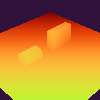

In [7]:
observed_img = renderer.render_multiobject(gt_poses, object_indices)
j.get_depth_image(observed_img[:,:,2])

In [8]:
absolute_poses_from_scene_graph_parallel_jit = jax.jit(jax.vmap(
    j.scene_graph.absolute_poses_from_scene_graph, in_axes=(None, None, None, 0, None, None)
))
SCALING_FACTOR = 3.0

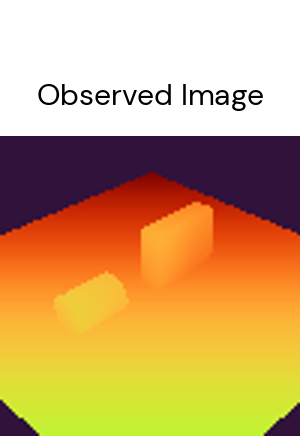

In [10]:
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
    ],
    middle_width=30
)

In [11]:
likelihood_jit = jax.vmap(jax.vmap(jax.vmap(j.threedp3_likelihood,
       in_axes=(None, None, None, None, 0, None)),
       in_axes=(None, None, None, 0, None, None)),
       in_axes=(None, 0, 0, None, None, None)                 
)

In [12]:
R_SWEEP = jnp.array([0.000001, 0.00001, 0.00005, 0.0001, 0.0005]).reshape(-1,1)
R = jnp.zeros((R_SWEEP.shape[0],0))
OUTLIER_PROBS = jnp.linspace(0.01, 0.5, 5)
OUTLIER_VOLUME = 1.0

In [13]:
R = jnp.hstack([R,R_SWEEP]) 
object_idx = 0
reconstruction = renderer.render_multiobject_parallel(
    jnp.tile(gt_poses[:,None,...], (1,2,1,1)), object_indices[:object_idx+1]
)
rendered_image, rendered_seg = reconstruction[:,:,:,:3], reconstruction[:,:,:, -1]
p = likelihood_jit(observed_img, rendered_image, rendered_seg, R, OUTLIER_PROBS, OUTLIER_VOLUME)

ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)

best_r, best_outlier_prob = (R_SWEEP[jj], OUTLIER_PROBS[kk])
print(best_r, best_outlier_prob)

[1.e-06] 0.1325


In [14]:
R = R.at[:,object_idx-1].set(best_r)
R = jnp.hstack([R,R_SWEEP]) 

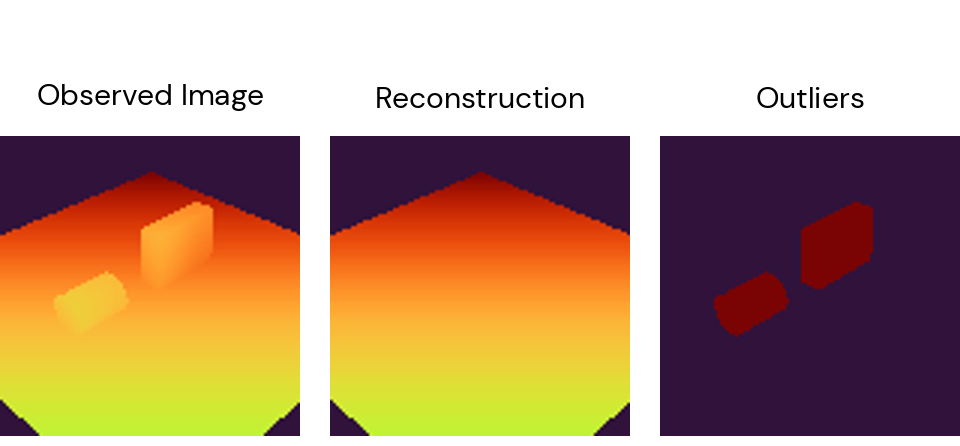

In [15]:

outliers = (
    (j.gaussian_mixture_image(observed_img, reconstruction[ii,:,:,:3], reconstruction[ii,:,:, -1], best_r) * (1.0 - best_outlier_prob)) 
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[ii,:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)

In [16]:
contact_params = jnp.array(
    [
        [0.0, 0.0, 0.0],
    ]
)
contact_param_grid = j.make_translation_grid_enumeration_3d(
    0.1, 0.0, 0.0,
    0.3, 0.3, 0.0,
    5,5,1
)

In [17]:
object_idx = 1

contact_params_tiled = jnp.tile(contact_params[None,...], (contact_param_grid.shape[0],1,1))
contact_params_tiled = jnp.concatenate([contact_params_tiled, contact_param_grid[:,None,...]],axis=1)
poses = absolute_poses_from_scene_graph_parallel_jit(
    absolute_poses[:object_idx+1], box_dims[:object_idx+1], edges[:object_idx+1], contact_params_tiled,
    face_parents[:object_idx+1], face_child[:object_idx+1]
)
reconstruction = renderer.render_multiobject_parallel(jnp.transpose(poses,axes=(1,0,2,3)), object_indices[:object_idx+1])
rendered_image, rendered_seg = reconstruction[:,:,:,:3], reconstruction[:,:,:, -1]


In [18]:
p = likelihood_jit(observed_img, rendered_image, rendered_seg, R, OUTLIER_PROBS, OUTLIER_VOLUME)
ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)

best_r, best_outlier_prob = (R_SWEEP[jj], OUTLIER_PROBS[kk])
print(ii,best_r, best_outlier_prob)

2 [1.e-06] 0.1325


In [19]:
contact_params_tiled[ii,:object_idx+1,:]

Array([[0. , 0. , 0. ],
       [0.2, 0. , 0. ]], dtype=float32)

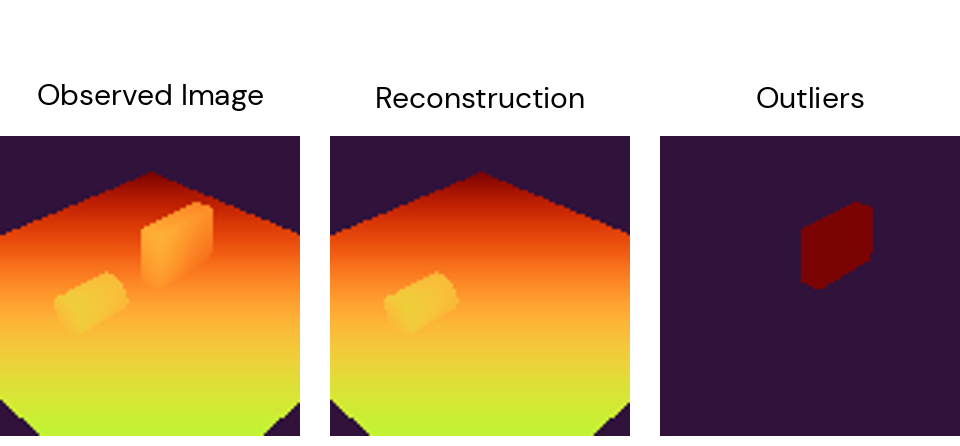

In [20]:
outliers = (
    (j.gaussian_mixture_image(observed_img, reconstruction[ii,:,:,:3], reconstruction[ii,:,:, -1], best_r) * (1.0 - best_outlier_prob)) 
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[ii,:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)

In [ ]:
contact_params = contact_params_tiled[weights.argmax(),:object_idx+1,:]


In [72]:
rendered_images.shape

(10000, 150, 150, 4)

In [69]:


weights = j.threedp3_likelihood_parallel_jit(observed_img, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
contact_params = contact_params_tiled[weights.argmax(),:object_idx+1,:]
reconstruction = rendered_images[weights.argmax()]
outliers = (
    (j.gaussian_mixture_image(observed_img, reconstruction, R) * (1.0 - OUTLIER_PROB)) 
        <
    (OUTLIER_PROB / OUTLIER_VOLUME)
)
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)

AttributeError: module 'jax3dp3' has no attribute 'threedp3_likelihood_parallel_jit'

Array([4024, 5996,   71, 1126,  242, 1989, 5776, 4426, 1518, 7906], dtype=int32)

(100,)

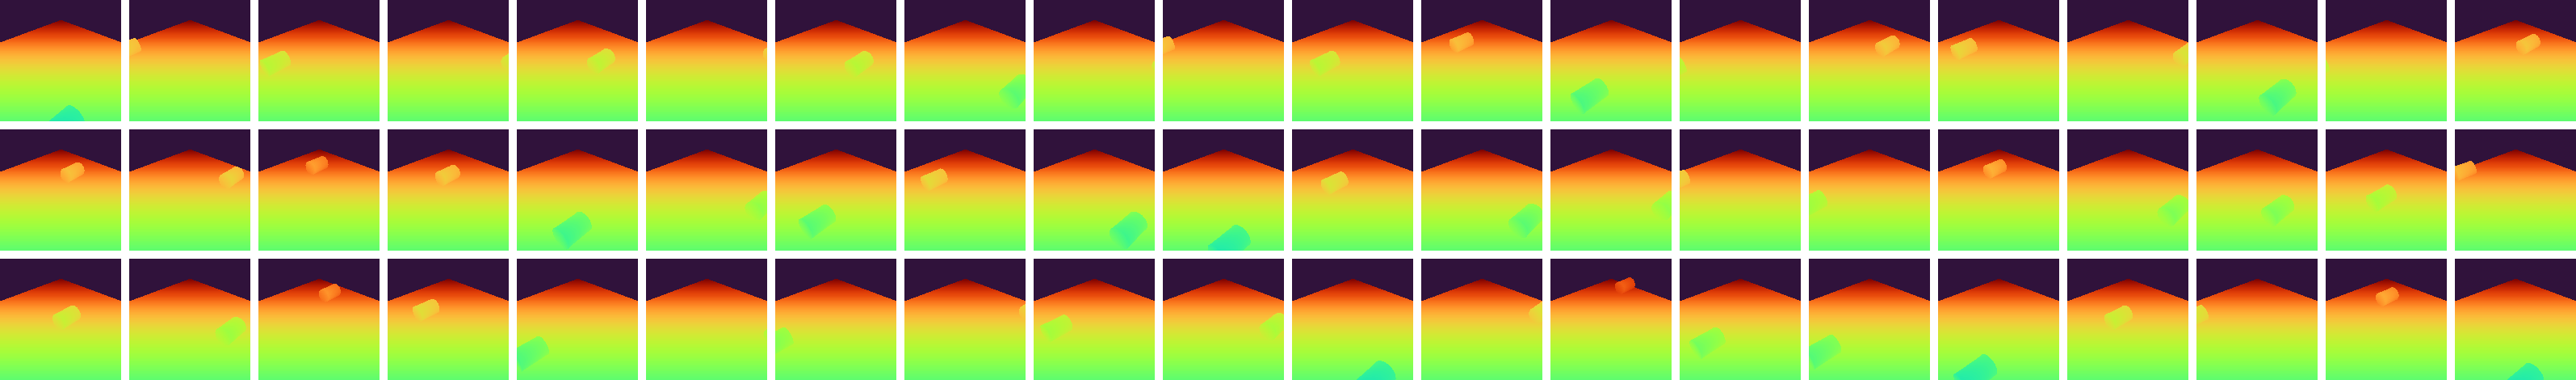

In [62]:
rows = 3
cols = 20
idxs = jax.random.choice(jax.random.PRNGKey(10),jnp.arange(rendered_images.shape[0]), shape=(rows*cols,))
j.hvstack_images([j.get_depth_image(rendered_images[idx,:,:,2]) for idx  in idxs], rows, cols)

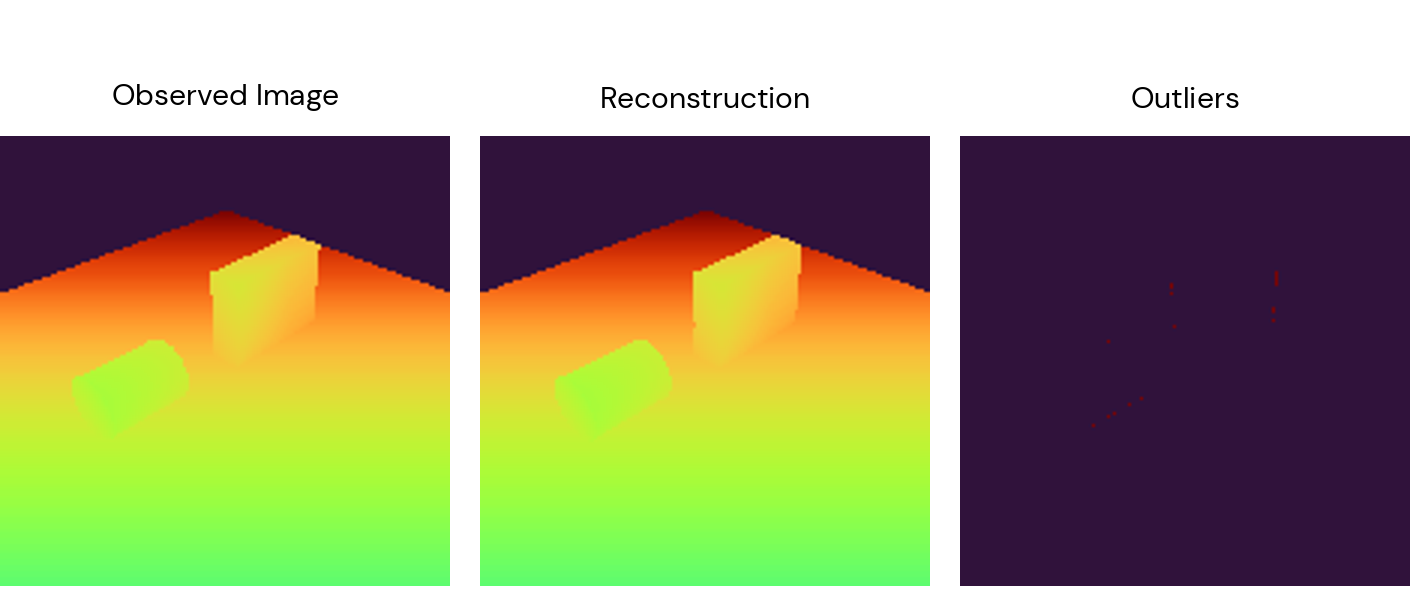

In [63]:
object_idx = 2

contact_params_tiled = jnp.tile(contact_params[None,...], (contact_param_grid.shape[0],1,1))
contact_params_tiled = jnp.concatenate([contact_params_tiled, contact_param_grid[:,None,...]],axis=1)
poses = absolute_poses_from_scene_graph_parallel_jit(
    absolute_poses[:object_idx+1], box_dims[:object_idx+1], edges[:object_idx+1], contact_params_tiled,
    face_parents[:object_idx+1], face_child[:object_idx+1]
)
rendered_images = renderer.render_multiobject_parallel(jnp.transpose(poses,axes=(1,0,2,3)), object_indices[:object_idx+1])
weights = j.threedp3_likelihood_parallel_jit(observed_img, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
contact_params = contact_params_tiled[weights.argmax(),:object_idx+1,:]
reconstruction = rendered_images[weights.argmax()]
outliers = (
    (j.gaussian_mixture_image(observed_img, reconstruction, R) * (1.0 - OUTLIER_PROB)) 
        <
    (OUTLIER_PROB / OUTLIER_VOLUME)
)
j.multi_panel(
    [
        j.scale_image(j.get_depth_image(observed_img[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *outliers), SCALING_FACTOR)
    ],
    labels=[
        "Observed Image",
        "Reconstruction",
        "Outliers",
    ],
    middle_width=30
)

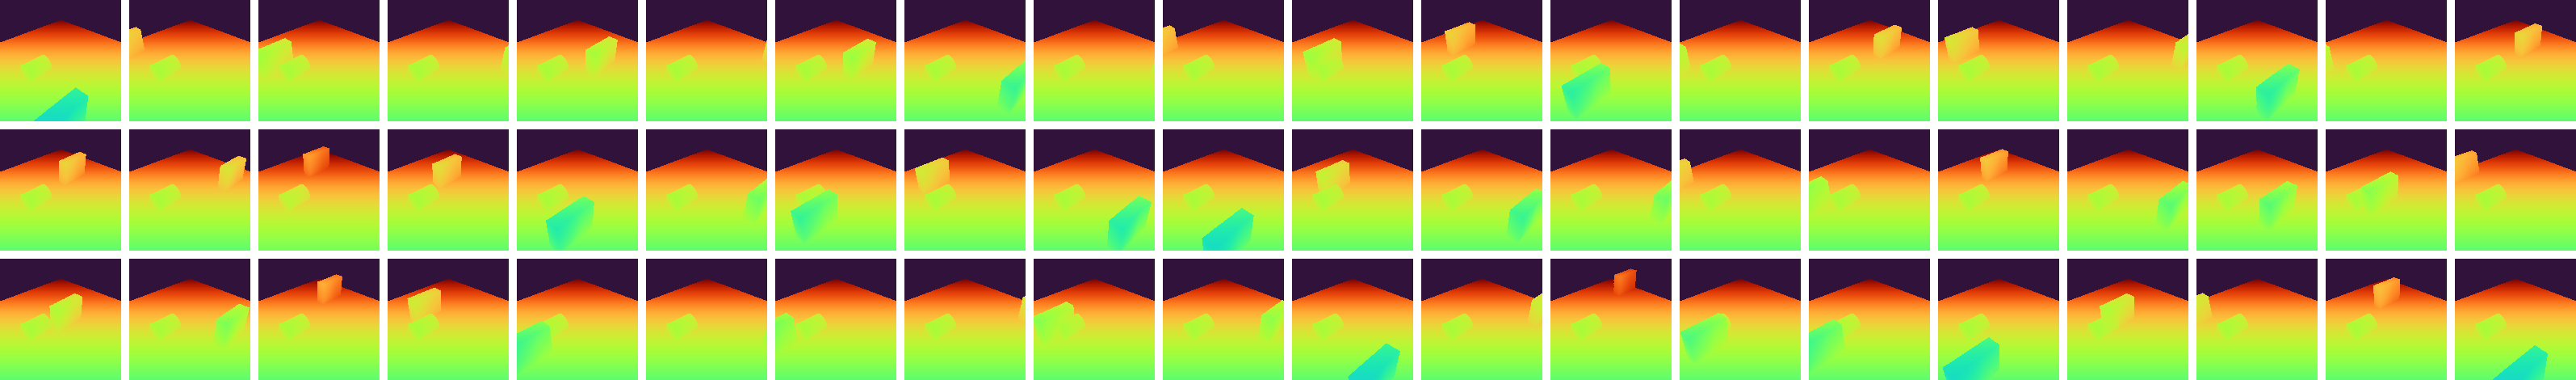

In [64]:
rows = 3
cols = 20
idxs = jax.random.choice(jax.random.PRNGKey(10),jnp.arange(rendered_images.shape[0]), shape=(rows*cols,))
j.hvstack_images([j.get_depth_image(rendered_images[idx,:,:,2]) for idx  in idxs], rows, cols)